# Task 1 - Modelling Natural Gas Prices

I am taking on the role of a QR at a commodity trading desk, looking to trade natural gas storage contracts.

Market data will be used to price the instrument accurately. The data will contain information about the market price of natural gas delivered at the end of each calendar month.

The dataset spans from October 31, 2020, to September 30, 2024.

I will analyze the data in order to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future to predict future prices.

To do this, an appropriate model which captures the variation in price will be used.

Natural Gas Dataset:

Dates: Dates formatted as MM-DD-YY
Prices: Market price of natural gas

# Data Preprocessing

In [4]:
# Importing Libaries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

In [5]:
# Reading in datasets
nat_gas = pd.read_csv("Nat_Gas.csv")

In [6]:
# Viewing first 5 rows of dataset
nat_gas.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [7]:
# Obtaining information regarding null values and datatypes
nat_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [8]:
# Convert the 'Dates' column to datetime format
nat_gas['Dates'] = pd.to_datetime(nat_gas['Dates'], format='%m/%d/%y')

In [9]:
# Ordering Data
nat_gas.set_index('Dates', inplace=True)

# EDA 

Time Series Decomposition: Decompose the time series into its trend, seasonal, and residual components.

Visualisation: Plot the price data over time to identify trends, seasonality, and potential outliers.

Stationarity Test: Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity in the time series.

Models for Comparison:
- Prophet
- Seasonal ARIMA (SARIMA)

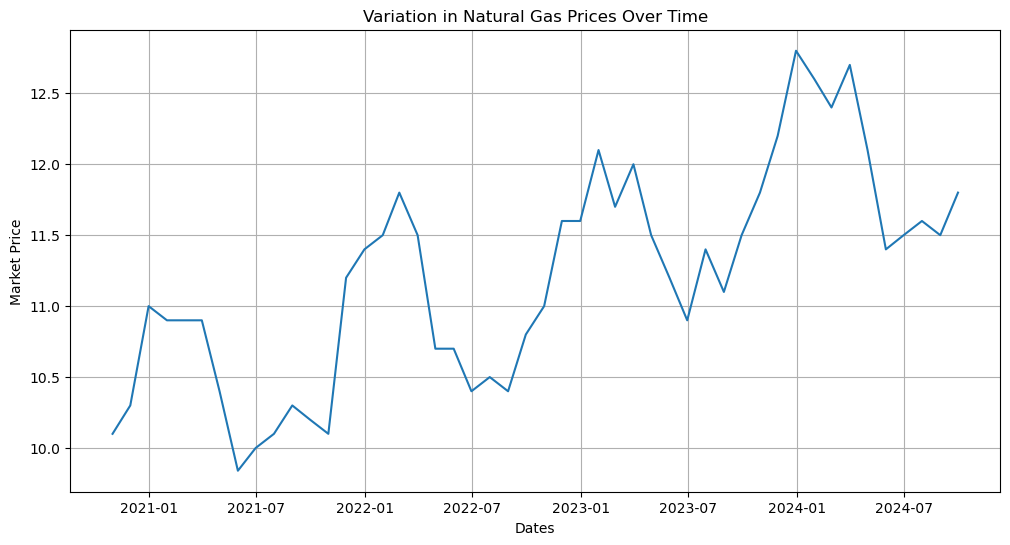

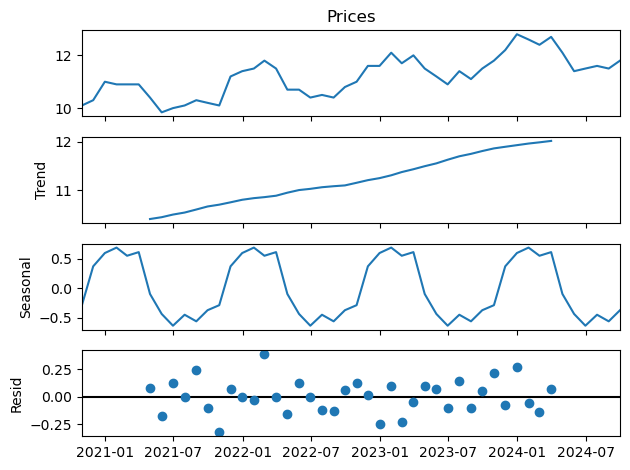

(0.21807686170000262,
 0.9732574388448695,
 10,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 10.198475035166396)

In [12]:
# 1. Visualize the price trend over time
plt.figure(figsize=(12, 6))
plt.plot(nat_gas.index, nat_gas["Prices"])
plt.title("Variation in Natural Gas Prices Over Time")
plt.xlabel("Dates")
plt.ylabel("Market Price")
plt.grid(True)
plt.show()

# 2. Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
adf_result = adfuller(nat_gas['Prices'])

# 3. Decompose the time series into trend, seasonality, and residuals
# Note: We will attempt seasonal decomposition, though with 48 data points, the results might be limited
decomposition = seasonal_decompose(nat_gas['Prices'], model='additive', period=12)

# Plotting the decomposition
decomposition.plot()
plt.show()

adf_result

1. Trend Visualisation:

The trend visualisation suggests an overall upward trend in natural gas prices over time, with fluctuations likely attributed to seasonal demand variations. Higher demand during colder months (e.g., winter) for heating purposes could contribute to price increases, while lower demand in warmer months might lead to price decreases.

2. ADF Test:

The ADF test yielded a p-value of 0.973, indicating that the time series is non-stationary. This means that the statistical properties of the series change over time, which can make forecasting more challenging.

3. Seasonal Decomposition:

The seasonal decomposition of the time series provides valuable insights into its components:

- Trend: The trend component reveals a positive upward direction in the data, suggesting a general increase in natural gas prices over time.
- Seasonality: While the seasonal component may be less pronounced with a limited dataset, it can potentially identify recurring patterns at specific intervals (e.g., seasonal fluctuations in demand).
- Residual: The residual component captures the random noise or irregular variations in the data that are not explained by the trend or seasonal patterns.

Given the exploratory data analysis, the time series of natural gas prices is non-stationary and exhibits potential seasonality.

For this task Prophet and SARIMA will be compared before detemrining which model to use going forwards.

While machine learning models like LSTM or SVMs can potentially capture seasonality, they may be prone to overfitting with a limited dataset and lack of relevant features. SARIMA is time series model which is also applicable.

## Prophet

In [16]:
# pip install prophet

In [17]:
from prophet import Prophet

16:11:49 - cmdstanpy - INFO - Chain [1] start processing
16:11:49 - cmdstanpy - INFO - Chain [1] done processing


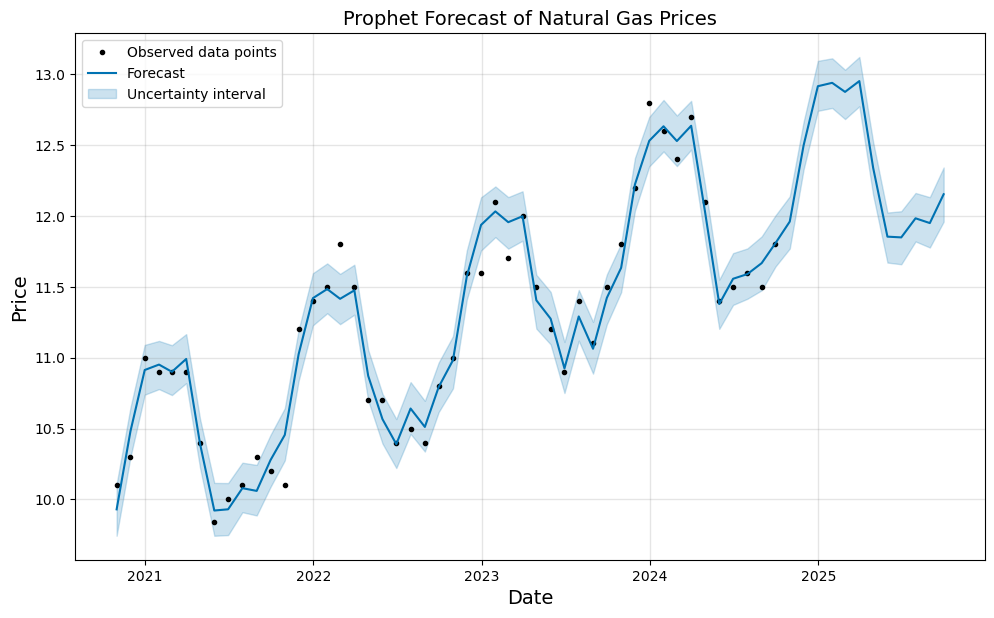

In [18]:
# Prepare data for Prophet
prophet_data = nat_gas.reset_index()[['Dates', 'Prices']].rename(columns={'Dates': 'ds', 'Prices': 'y'})

# Initialise and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Create a future DataFrame for the next 12 months
future_dates = prophet_model.make_future_dataframe(periods=12, freq='ME')

# Forecast using the model
prophet_forecast = prophet_model.predict(future_dates)

# Plot the forecast
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecast of Natural Gas Prices', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()
plt.show()


In [19]:
# Show the forecast for future dates
forecast_data = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)
forecast_data

,ds,yhat,yhat_lower,yhat_upper
48,2024-10-31,11.960253,11.769691,12.138068
49,2024-11-30,12.497222,12.327683,12.663692
50,2024-12-31,12.915387,12.741697,13.094259
51,2025-01-31,12.939215,12.761929,13.112215
52,2025-02-28,12.875286,12.683562,13.031339
53,2025-03-31,12.951613,12.773823,13.121946
54,2025-04-30,12.339306,12.147386,12.521366
55,2025-05-31,11.853801,11.670921,12.023853
56,2025-06-30,11.848579,11.658990,12.033252
57,2025-07-31,11.983327,11.819966,12.162060


In [20]:
# Extract the last row from the nat_gas dataset and reset the index
last_point = nat_gas.reset_index().tail(1)

# Rename columns for compatibility with forecast_data
last_point = last_point.rename(columns={"Dates":"ds", "Prices":"yhat"})

# Append the last row to the forecast_data DataFrame
forecast_data = pd.concat([last_point, forecast_data])

# Fill NaN values in forecast intervals with 11.800000
forecast_data.yhat_lower.fillna(11.800000, inplace=True)
forecast_data.yhat_upper.fillna(11.800000, inplace=True)

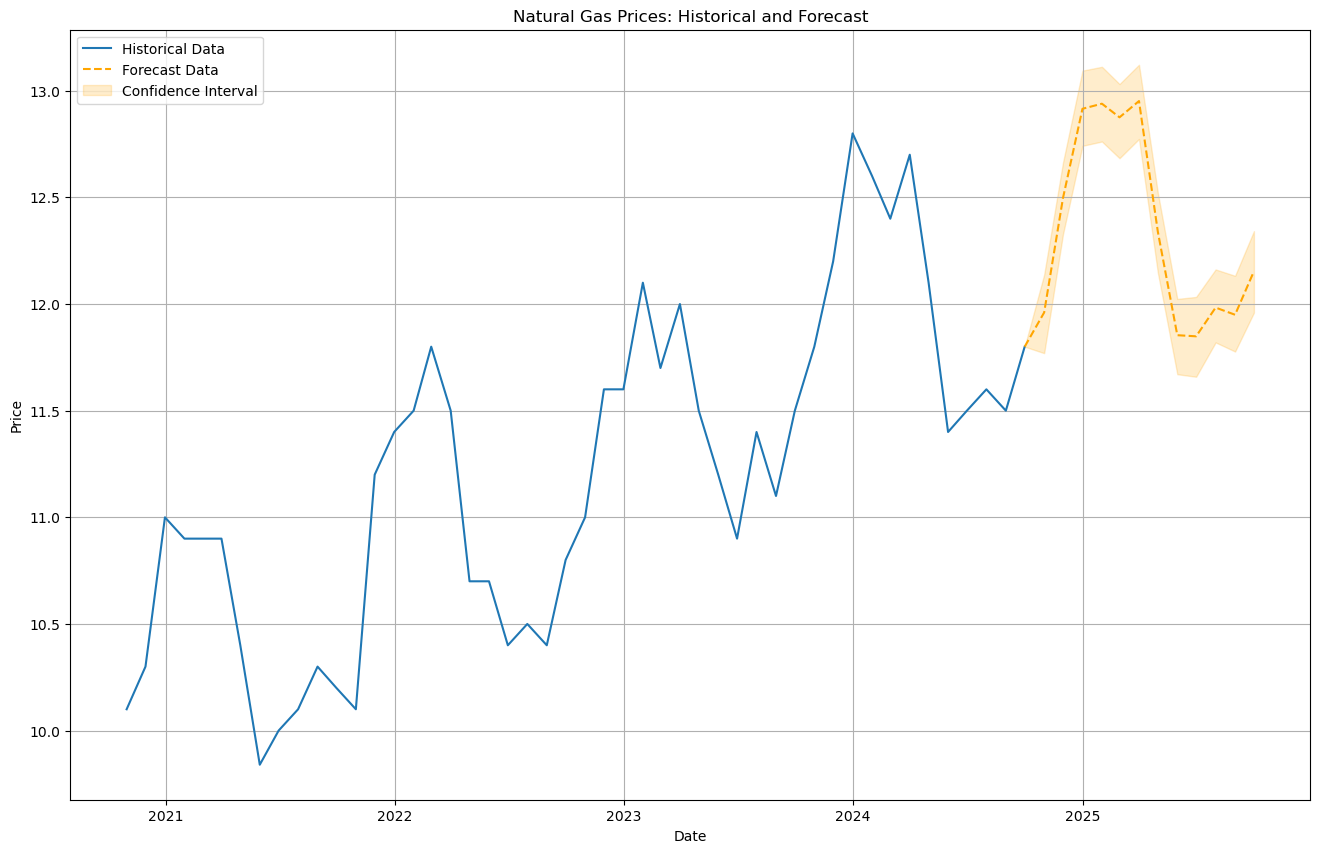

In [21]:
# Set up the figure size
plt.figure(figsize=(16,10))

# Plot historical data
plt.plot(nat_gas.index, nat_gas['Prices'], label='Historical Data')

# Plot forecast data
plt.plot(forecast_data["ds"], forecast_data["yhat"], label='Forecast Data', linestyle='--', color='orange')

# Fill the area between confidence intervals
plt.fill_between(forecast_data['ds'], forecast_data['yhat_lower'], forecast_data['yhat_upper'], 
                 color='orange', alpha=0.2, label='Confidence Interval')

# Add plot title and labels
plt.title('Natural Gas Prices: Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(nat_gas.reset_index()["Prices"], prophet_forecast["yhat"].iloc[:48])
print(f"MSE for Prophet: {mse}")

MSE for Prophet: 0.0191687906480319


## SARIMA

In [24]:
import pmdarima as pm

In [25]:
series = nat_gas['Prices']

In [26]:
model = pm.auto_arima(series, 
                      seasonal=True, 
                      m=12,  # Adjust based on the seasonality of your data
                      stepwise=True, 
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=36.454, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=39.688, Time=0.21 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=39.336, Time=0.50 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.769, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=36.098, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953,

In [27]:
# Define and fit the SARIMA model
sarima_model = SARIMAX(series,
                       order=(2, 1, 0),  # Non-seasonal parameters
                       seasonal_order=(2, 1, 0, 12))  # Seasonal parameters
sarima_fit = sarima_model.fit()




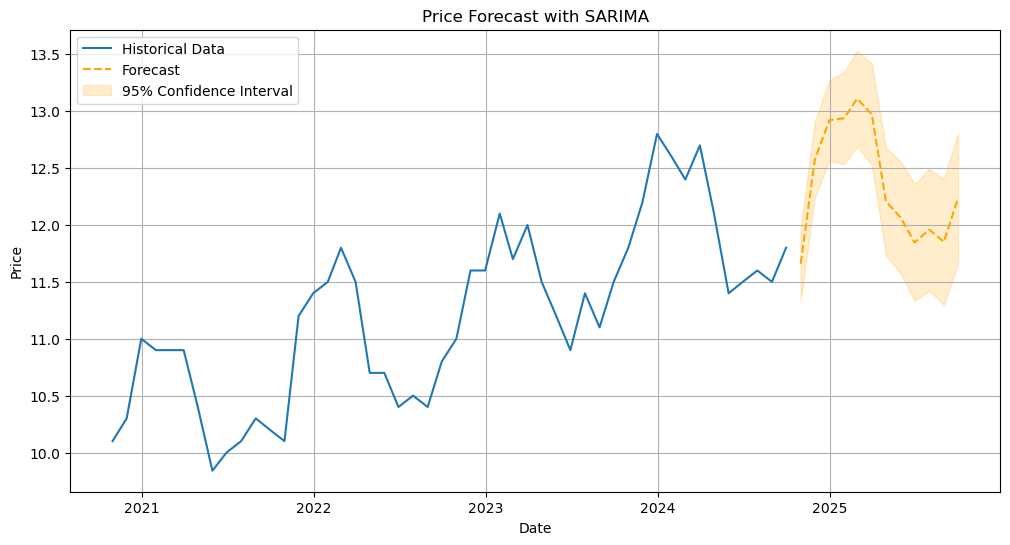

In [28]:
# Forecast the next 12 periods
forecast = sarima_fit.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int(alpha=0.05)

# Prepare forecast DataFrame
forecast_index = pd.date_range(start=series.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': forecast_conf_int['lower Prices'],
    'Upper CI': forecast_conf_int['upper Prices']
}, index=forecast_index)

# Plot historical data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(series, label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='orange', linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title('Price Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Generate in-sample forecasts
in_sample_forecast = sarima_fit.get_prediction(start=series.index[0], end=series.index[-1])
in_sample_pred_mean = in_sample_forecast.predicted_mean
in_sample_conf_int = in_sample_forecast.conf_int(alpha=0.05)

# Ensure that forecast indices align with the original series index
forecast_start = in_sample_forecast.predicted_mean.index[0]
forecast_end = in_sample_forecast.predicted_mean.index[-1]

# Calculate Mean Squared Error
mse = mean_squared_error(series, in_sample_pred_mean)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 2.7557


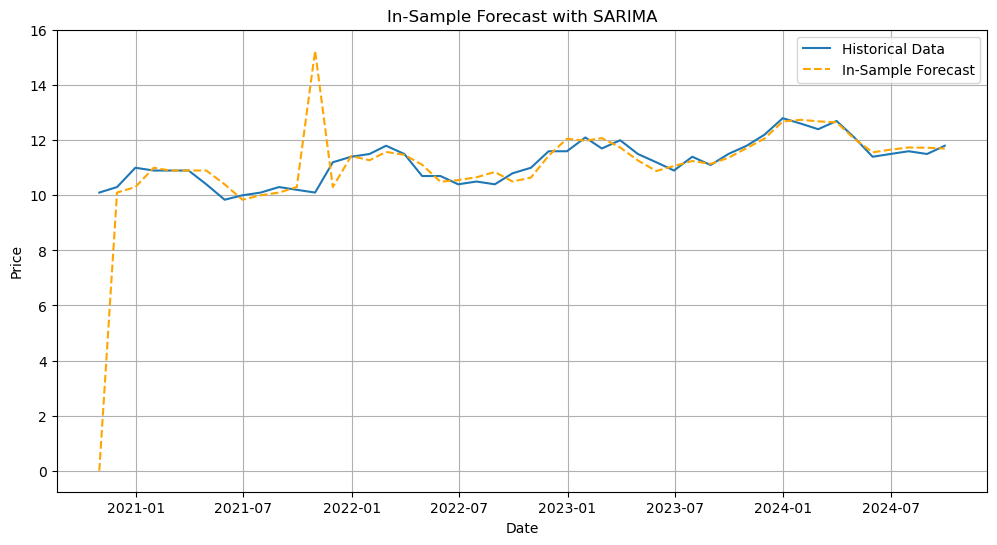

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(series, label='Historical Data')
plt.plot(in_sample_pred_mean.index, in_sample_pred_mean, label='In-Sample Forecast', color='orange', linestyle='--')
# plt.fill_between(in_sample_conf_int.index, in_sample_conf_int['lower Prices'], in_sample_conf_int['upper Prices'], color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title('In-Sample Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Model Building

Due to the ease of applying the prophet model and it's low MSE value this will be the model used going forwards

In [33]:
nat_gas.reset_index(inplace = True)

In [34]:
nat_gas[nat_gas.Dates == "2020-10-31"]["Prices"][0]

10.1

In [75]:
import datetime as dt

def get_price_predictions(dates):
    # Check if dates is a list
    if not isinstance(dates, list):
        raise ValueError("The input should be a list of dates.")
    
    # Initialize an empty list to store predictions
    predictions = []
    
    # Convert list of dates to a DataFrame for Prophet
    df_dates = pd.DataFrame({'ds': [dt.datetime.strptime(date, "%Y-%m-%d") if isinstance(date, str) else date for date in dates]})
    
    # Ensure 'ds' column is in the correct datetime format
    df_dates['ds'] = pd.to_datetime(df_dates['ds'])
    
    # Predict using Prophet model
    forecast = prophet_model.predict(df_dates)
    
    # Extract and rename columns of interest
    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Rename columns
    forecast_df = forecast_df.rename(
        columns={
            "ds": "Dates",
            "yhat": "Predicted Price",
            "yhat_lower": "Lower Bound Uncertainty Interval",
            "yhat_upper": "Upper Bound Uncertainty Interval"
        }
    )
    
    return forecast_df

In [77]:
dates = ["2024-09-01", "2024-10-01", dt.datetime(2024, 11, 1), "2026-01-14"]
forecast_df = get_price_predictions(dates)
forecast_df


,Dates,Predicted Price,Lower Bound Uncertainty Interval,Upper Bound Uncertainty Interval
0,2024-09-01,11.926671,11.752798,12.099244
1,2024-10-01,11.836000,11.655514,12.019418
2,2024-11-01,11.941295,11.766262,12.135102
3,2026-01-14,13.559415,13.383863,13.745920
